In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize
import ddm
import ddm.plot
import os 
import paranoid as pns
pns.settings.Settings.set(enabled=False)

# Loss function definitions

In [2]:
class LossByMeans(ddm.LossFunction):
    # This is a shortcut loss function for optimizing fit to accuracy and mean RT, as opposed to full RT distribution
    name = 'Mean correct RT and accuracy'
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
        self.exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
        
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        MSE = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            mean_rt_exp_cor = self.exp_data[(self.exp_data.tta_condition == comb['tta_condition']) & 
                                            self.exp_data.is_turn_decision == True].RT.mean()
            comb_sample = self.sample.subset(**comb)
            MSE += (sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                MSE += (sols[c].mean_decision_time() - mean_rt_exp_cor)**2
        return MSE
    
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        solultions = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(solultions[c].prob_correct() - comb_sample.prob_correct())**2
            if solultions[c].prob_correct() > 0:
                model_rt_q = self.get_rt_quantiles(solultions[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                # this can be modified from R&T 2002: *comb_sample.prob_correct() can be removed to improve RT fit at low-p trials
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS

# Helper functions

In [25]:
def get_model_measures(model, tta_condition):
    sol = model.solve(conditions={'tta_condition': tta_condition})
    return tta_condition, sol.prob_correct(), sol.mean_decision_time()
        
def save_fitting_results(exp_data, fit_model):
    print(fit_model.name)
    print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
    print('Number of parameters: %i' % (len(fit_model.get_model_parameters())-1))
    print('Parameter values: ', fit_model.get_model_parameters())
    
    directory = 'model_fit_results/%s' % (fit_model.name.lower().replace(' ', '_'))
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    model_measures = [get_model_measures(fit_model, tta_condition) for tta_condition in exp_data.tta_condition.unique()]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'is_turn_decision', 'RT'])
    model_measures['loss'] = fit_model.get_fit_result().value()    
    model_measures.to_csv(os.path.join(directory, 'measures.csv'), index=False)
    
    rt_dfs = []
    for i, tta_condition in enumerate(exp_data.tta_condition.unique()):
        sol = fit_model.solve(conditions={'tta_condition': tta_condition})
        rt_df = pd.DataFrame({'condition': tta_condition,
                              't': fit_model.t_domain(),
                              'rt_corr_pdf': sol.pdf_corr()/sol.prob_correct()})
        rt_dfs.append(rt_df)
    rt_dfs = pd.concat(rt_dfs)
    rt_dfs.to_csv(os.path.join(directory, 'rt_pdf.csv'), index=False)

# Model definitions

Duration of model simulations is set to 2.5 (upper boundary on experimentally observed response times)

In [4]:
T_dur = 2.5

### Model 1. DDM with TTA-dependent drift 

In [5]:
class DriftTta(ddm.models.Drift):
    name = 'Drift depends on TTA'
    required_parameters = ['alpha', 'tta_crit']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        return self.alpha*(conditions['tta_condition'] - t - self.tta_crit)

In [6]:
model_tta_dependent_drift = ddm.Model(name='1 TTA-dependent drift',
                                      drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      T_dur=T_dur)

### Model 2. Model 1 + nondecision time

In [7]:
model_nondecision_time_fixed = ddm.Model(name='2 TTA-dependent drift and fixed nondecision time',
                                      drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      overlay=ddm.OverlayNonDecision(nondectime=ddm.Fittable(minval=0, maxval=0.5)),
                                      T_dur=T_dur)

### Model 3. Model 2 + nondecision time variability

In [8]:
model_nondecision_time_variable = ddm.Model(name='3 TTA-dependent drift and uniformly distributed nondecision time',
                                     drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                    tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                     noise=ddm.NoiseConstant(noise=1),
                                     bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                     overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                           halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                     T_dur=T_dur)

### Model 4. Model 3 + collapsing bounds

In [16]:
model_collapsing_bounds = ddm.Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds',
                                    drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3), 
                                                   tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                    noise=ddm.NoiseConstant(noise=1),
                                    bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=0.5, maxval=5), 
                                                                         tau=ddm.Fittable(minval=0.5, maxval=5)),
                                    overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                          halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                    T_dur=T_dur)

### Model 5. Model 3 + TTA-dependent bounds

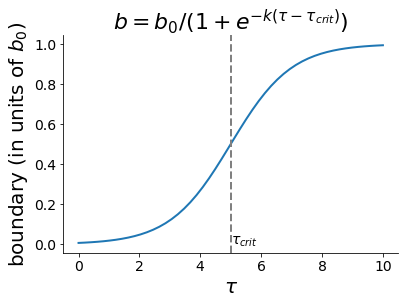

In [10]:
b_0 = 1
k = 1
tta_crit = 5
tau = np.linspace(0, 10)
b = lambda tau: b_0/(1+np.exp(-k*(tau-tta_crit)))

fig, ax = plt.subplots()
ax.plot(tau, b(tau))
ax.axvline(tta_crit, color='grey', ls='--')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('boundary (in units of $b_0$)')
# ax.legend(loc='lower right')
ax.set_title(r'$b = b_0/(1+e^{-k(\tau-\tau_{crit})})$')
ax.text(x=tta_crit, y=0, s=r'$\tau_{crit}$', fontsize=14);

In [11]:
class BoundCollapsingTta(ddm.models.Bound):
    name = 'Bounds collapsing with TTA'
    required_parameters = ['b_0', 'k', 'tta_crit']
    required_conditions = ['tta_condition'] 
    def get_bound(self, t, conditions, **kwargs):
        tau = conditions['tta_condition'] - t
        return self.b_0/(1+np.exp(-self.k*(tau-self.tta_crit)))

tta_crit = ddm.Fittable(minval=3, maxval=6)
    
model_TTA_bounds = ddm.Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time',
                             drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                            tta_crit=tta_crit),
                             noise=ddm.NoiseConstant(noise=1),
                             bound=BoundCollapsingTta(b_0=ddm.Fittable(minval=0.5, maxval=5), 
                                                      k=ddm.Fittable(minval=0.1, maxval=2),
                                                      tta_crit=tta_crit),
                             overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                   halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                             T_dur=T_dur)

# Model fitting

Reading experimental data

In [14]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

In [ ]:
models = [model_tta_dependent_drift, 
          model_nondecision_time_fixed, 
          model_nondecision_time_variable,
          model_collapsing_bounds, 
          model_TTA_bounds]

fit_models = []
for model in models:
    print(model.name)
    fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model, lossfunction=LossWLS)
    save_fitting_results(exp_data, fit_model)
    fit_models.append(fit_model)

In [26]:
for fit_model in fit_models:
    save_fitting_results(exp_data, fit_model)

1 TTA-dependent drift
Loss function value: 0.19168
Number of parameters: 3
Parameter values:  [Fitted(0.5867959085434452, minval=0.1, maxval=3), Fitted(4.684847440722532, minval=3, maxval=6), 1, Fitted(0.9341252914626389, minval=0.1, maxval=3.0)]
2 TTA-dependent drift and fixed nondecision time
Loss function value: 0.02783
Number of parameters: 4
Parameter values:  [Fitted(0.6941550065736614, minval=0.1, maxval=3), Fitted(5.0294822308970435, minval=3, maxval=6), 1, Fitted(0.6350285903762585, minval=0.1, maxval=3.0), Fitted(0.26816256663482235, minval=0, maxval=0.5)]
3 TTA-dependent drift and uniformly distributed nondecision time
Loss function value: 0.01241
Number of parameters: 5
Parameter values:  [Fitted(0.8167374305341593, minval=0.1, maxval=3), Fitted(5.125750905461382, minval=3, maxval=6), 1, Fitted(0.5305367251573412, minval=0.1, maxval=3.0), Fitted(0.35849451597598103, minval=0, maxval=0.5), Fitted(0.24451154993591956, minval=0, maxval=0.3)]
4 TTA-dependent drift and uniformly